In [1]:
%matplotlib inline
import json
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import glob
import time

from scipy.ndimage.measurements import label
import pandas as pd
#import keras.backend as K
from sklearn.metrics import jaccard_similarity_score
 
import time
import numpy
from PIL import Image, ImageDraw
import re
from shapely.geometry import Polygon
from pprint import pprint
import PIL.ImageDraw
from PIL import Image
import argparse
import os
from tqdm import tqdm

In [4]:
#df is the dataset that we are annotating
#raw_df is the dataset that the organizers provided
#adding path for json anf image folders respectively
import os
cwd = os.getcwd()
provided_data_file_dir= cwd+'/datasets/training_GT_labels_v2.json'#json provided by the organizers of the challange
our_data_file_dir=cwd+'/datasets/export-2019-02-28T10_42_47.657Z.json'#our annotated dataset
img_file_dir=cwd+'/datasets/Data_Training/'#folder where images are stored
provided_df = pd.read_json(provided_data_file_dir)
df = pd.read_json(our_data_file_dir)

 
#adding a complete path for the image 
df['External ID']= [img_file_dir + u for u in df['External ID']]#iris_data_dir + new_df['parcel_id'].astype(str) + '.jpg'

df['images']=[u.split('/',7)[7] for u in df['External ID']]
raw_df=pd.DataFrame()
raw_df['images']=list(provided_df.columns.values)
raw_df['img_path']=[img_file_dir +  u for u in raw_df['images']]

raw_df['raw_inner_poly']=[ provided_df[u][0] for u in raw_df['images']]

raw_df.head()

images                                           img_path  \
0      IMG_5677.JPG  /home/shrek/alphapilot/AlphaPilot_test2/datase...   
1  IMG_7088 (1).JPG  /home/shrek/alphapilot/AlphaPilot_test2/datase...   
2      IMG_0260.JPG  /home/shrek/alphapilot/AlphaPilot_test2/datase...   
3      IMG_4609.JPG  /home/shrek/alphapilot/AlphaPilot_test2/datase...   
4      IMG_2994.JPG  /home/shrek/alphapilot/AlphaPilot_test2/datase...   

                             raw_inner_poly  
0  [532, 354, 772, 357, 768, 594, 533, 592]  
1  [451, 226, 831, 247, 836, 623, 437, 622]  
2  [480, 373, 698, 374, 698, 599, 471, 594]  
3  [495, 309, 668, 285, 672, 554, 499, 533]  
4  [490, 190, 637, 345, 644, 686, 475, 679]

In [5]:
#remove white spaces from image path
s=raw_df['images'][1]
print(re.sub(r"\s+", "", s))  # \s matches all white spaces

IMG_7088(1).JPG


In [6]:
#Remove whitespaces from image names by rename
import os
for dirname in os.listdir("."):
    if os.path.isdir(img_file_dir):
        for i, filename in enumerate(os.listdir(img_file_dir)):
            os.rename(img_file_dir + "/" + filename, img_file_dir + "/" + re.sub(r"\s+", "", filename))

In [7]:
df_all=pd.merge(df, raw_df, on='images')
df_all.head(10)

Agreement                Created At               Created By  \
0        NaN  2019-02-06T08:35:37.000Z  alberto.galet@gmail.com   
1        NaN  2019-02-06T08:36:22.000Z  alberto.galet@gmail.com   
2        NaN  2019-02-06T08:36:55.000Z  alberto.galet@gmail.com   
3        NaN  2019-02-07T02:17:15.000Z  alberto.galet@gmail.com   
4        NaN  2019-02-07T02:18:01.000Z  alberto.galet@gmail.com   
5        NaN  2019-02-07T02:18:42.000Z  alberto.galet@gmail.com   
6        NaN  2019-02-07T02:19:13.000Z  alberto.galet@gmail.com   
7        NaN  2019-02-07T02:19:47.000Z  alberto.galet@gmail.com   
8        NaN  2019-02-07T02:20:22.000Z  alberto.galet@gmail.com   
9        NaN  2019-02-07T02:20:56.000Z  alberto.galet@gmail.com   

                  DataRow ID         Dataset Name  \
0  cjrsurb5r9p7w0anvd23j1pgg  Test2 AlphaPilot #2   
1  cjrsurb5v9p800anv2xkrhfkw  Test2 AlphaPilot #2   
2  cjrsurb5v9p840anv7ly4rt5s  Test2 AlphaPilot #2   
3  cjrsurb5v9p880anvyjs4m1oj  Test2 AlphaPilot #2   
4  cjrsurb5v9p8c0anvcve1d63y  Test2 AlphaPilot #2   
5  cjrsurb5v9p8g0anv2ji1v57l  Test2 AlphaPilot #2   
6  cjrsurb5v9p8k0anv1auzm8e0  Test2 AlphaPilot #2   
7  cjrsurb5v9p8o0anv56veqecf  Test2 AlphaPilot #2   
8  cjrsurb5v9p8s0anvm6kjs3ge  Test2 AlphaPilot #2   
9  cjrsurb5v9p8w0anvcfa1y38p  Test2 AlphaPilot #2   

                                         External ID  \
0  /home/shrek/alphapilot/AlphaPilot_test2/datase...   
1  /home/shrek/alphapilot/AlphaPilot_test2/datase...   
2  /home/shrek/alphapilot/AlphaPilot_test2/datase...   
3  /home/shrek/alphapilot/AlphaPilot_test2/datase...   
4  /home/shrek/alphapilot/AlphaPilot_test2/datase...   
5  /home/shrek/alphapilot/AlphaPilot_test2/datase...   
6  /home/shrek/alphapilot/AlphaPilot_test2/datase...   
7  /home/shrek/alphapilot/AlphaPilot_test2/datase...   
8  /home/shrek/alphapilot/AlphaPilot_test2/datase...   
9  /home/shrek/alphapilot/AlphaPilot_test2/datase...   

                          ID  \
0  cjrsxucjqqkbd0b47j8vcjsua   
1  cjrsxvb54qkw90b47dwa8uupg   
2  cjrsxw0feqs9n08984nfshogi   
3  cjrtzrm18i8ga08983qewu7rq   
4  cjrtzslxpi69j0b4753lkl3ju   
5  cjrtzth7bi7210b47l0yydz0t   
6  cjrtzu5bziasw0898zn0xuaez   
7  cjrtzuvrni8r10b47jq56iqvh   
8  cjrtzvm6xibyq089861ts75g5   
9  cjrtzwcfmi9t30b47ily7qitc   

                                               Label  \
0  {'Outer Border': [{'geometry': 'POLYGON ((997 ...   
1  {'Outer Border': [{'geometry': 'POLYGON ((894 ...   
2  {'Outer Border': [{'geometry': 'POLYGON ((848 ...   
3  {'Outer Border': [{'geometry': 'POLYGON ((597 ...   
4  {'Outer Border': [{'geometry': 'POLYGON ((359 ...   
5  {'Outer Border': [{'geometry': 'POLYGON ((567 ...   
6  {'Outer Border': [{'geometry': 'POLYGON ((343 ...   
7  {'Outer Border': [{'geometry': 'POLYGON ((753 ...   
8  {'Outer Border': [{'geometry': 'POLYGON ((585 ...   
9  {'Outer Border': [{'geometry': 'POLYGON ((471 ...   

                                        Labeled Data      Project Name  \
0  https://storage.googleapis.com/labelbox-193903...  Test2 AlphaPilot   
1  https://storage.googleapis.com/labelbox-193903...  Test2 AlphaPilot   
2  https://storage.googleapis.com/labelbox-193903...  Test2 AlphaPilot   
3  https://storage.googleapis.com/labelbox-193903...  Test2 AlphaPilot   
4  https://storage.googleapis.com/labelbox-193903...  Test2 AlphaPilot   
5  https://storage.googleapis.com/labelbox-193903...  Test2 AlphaPilot   
6  https://storage.googleapis.com/labelbox-193903...  Test2 AlphaPilot   
7  https://storage.googleapis.com/labelbox-193903...  Test2 AlphaPilot   
8  https://storage.googleapis.com/labelbox-193903...  Test2 AlphaPilot   
9  https://storage.googleapis.com/labelbox-193903...  Test2 AlphaPilot   

  Reviews  Seconds to Label  \
0      []            33.832   
1      []            44.299   
2      []            31.955   
3      []            39.032   
4      []            46.003   
5      []            39.919   
6      []            30.653   
7      []            33.630   


In [9]:

keep_cols=['images', 'img_path','Label','raw_inner_poly']
df_all=df_all[keep_cols]
df_all['outer_poly']=''
df_all['inner_poly']=''
df_all['outer_x_min']=''
df_all['outer_y_min']=''
df_all['outer_x_max']=''
df_all['outer_y_max']=''
df_all['inner_x_min']=''
df_all['inner_y_min']=''
df_all['inner_x_max']=''
df_all['inner_y_max']=''
df_all['class_id']= ''
print(len(df_all))
df_all.head()

4943


images                                           img_path  \
0  IMG_0015.JPG  /home/shrek/alphapilot/AlphaPilot_test2/datase...   
1  IMG_0158.JPG  /home/shrek/alphapilot/AlphaPilot_test2/datase...   
2  IMG_0244.JPG  /home/shrek/alphapilot/AlphaPilot_test2/datase...   
3  IMG_0367.JPG  /home/shrek/alphapilot/AlphaPilot_test2/datase...   
4  IMG_0374.JPG  /home/shrek/alphapilot/AlphaPilot_test2/datase...   

                                               Label  \
0  {'Outer Border': [{'geometry': 'POLYGON ((997 ...   
1  {'Outer Border': [{'geometry': 'POLYGON ((894 ...   
2  {'Outer Border': [{'geometry': 'POLYGON ((848 ...   
3  {'Outer Border': [{'geometry': 'POLYGON ((597 ...   
4  {'Outer Border': [{'geometry': 'POLYGON ((359 ...   

                             raw_inner_poly outer_poly inner_poly outer_x_min  \
0  [504, 191, 902, 177, 915, 580, 495, 584]                                     
1  [454, 212, 803, 221, 808, 552, 454, 566]                                     
2  [590, 376, 791, 371, 794, 589, 577, 601]                                     
3  [836, 385, 641, 387, 635, 582, 841, 582]                                     
4  [470, 221, 848, 231, 851, 613, 457, 609]                                     

  outer_y_min outer_x_max outer_y_max inner_x_min inner_y_min inner_x_max  \
0                                                                           
1                                                                           
2                                                                           
3                                                                           
4                                                                           

  inner_y_max class_id  
0                       
1                       
2                       
3                       
4

raw_inner_poly [632, 437, 718, 445, 720, 580, 632, 587]
poly [632, 437, 718, 445, 720, 580, 632, 587]
raw_inner_poly [571, 404, 698, 425, 686, 603, 565, 601]
poly [571, 404, 698, 425, 686, 603, 565, 601]


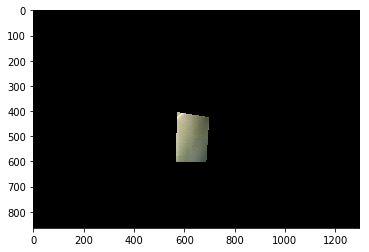

In [10]:
# checking the mask from the provided GT by the organizers

#processing the polygone and creating a mask
def get_mask_raw_data(img_shape, poly,display=False):
    output_mask = np.zeros(img_shape[:2], dtype=np.uint8)
    print('poly',poly)

    coords =  zip(*[iter(poly)] * 2) 
     
    mask = np.zeros(img_shape[:2], dtype=np.uint8)
    mask = PIL.Image.fromarray(mask)
    draw = PIL.ImageDraw.Draw(mask)
    x = []
    y = []
    polygons = []

    for pt in coords:
        a = (int(pt[0]), int(pt[1]))
        polygons.append(a)
        init_x = (int(pt[0]))
        init_y = (int(pt[1]))

        x.append(init_x)
        y.append(init_y)
    proc_polygons=np.vstack((x,y)).T
    x,y,w,h = cv2.boundingRect(proc_polygons) 
    draw.polygon(xy=polygons, outline=1, fill=1)
    mask = np.array(mask, dtype=bool)
    if display:
        plt.imshow(mask)
        plt.show
    return mask
for i in range(444,446):#len(df)):

    img=cv2.imread(df_all['img_path'][i])
    row=img.shape[0]
    col=img.shape[1]
    img_shape = (row,col)
    #outer_poly=df['Label'][i] 
    inner_poly=df_all['raw_inner_poly'][i]
    if inner_poly:
        print('raw_inner_poly',inner_poly)
    #outer_mask=get_mask(img_shape,outer_poly,display=False)
        inner_mask=get_mask_raw_data(img_shape,inner_poly,display=False)
        inner_mask.dtype='uint8'
    #outer_mask.dtype='uint8'
    #final_mask=cv2.subtract(outer_mask,inner_mask)
        plt.imshow(cv2.bitwise_and(img,img,mask=inner_mask))
        plt.show
    else:
        print('polygon data corruption detected for index:', i)

In [11]:
#convert the polygons into a format that can be convereted to bounding boxes 
from tqdm import tqdm
#preprocessing our_dataset

def convert_coordinates(poly):
    proc_poly=poly[0]['geometry']
    nums =  re.findall(r'\d+(?:\.\d*)?', proc_poly.rpartition(',')[0])
    coords =  zip(*[iter(nums)] * 2)
    polygons = []
    for pt in coords:
        a = (int(pt[0]), int(pt[1]))
        polygons.append(a)
    
    return polygons 
def convert_coordinates_raw(polygon):
    poly=[]
    polygon =  zip(*[iter(polygon)] * 2)
    for p in polygon:
        poly.append(p)
    return poly
def get_bbox(polygon):
    polygon=polygon[0]['geometry']
    polygon=(polygon)

    polygon =  re.findall(r'\d+(?:\.\d*)?', polygon)
    polygon =  zip(*[iter(polygon)] * 2)
    x = []
    y = []
    for pt in polygon:
        init_x = (int(pt[0]))
        init_y = (int(pt[1]))

        x.append(init_x)
        y.append(init_y)
    polygons=np.vstack((x,y)).T
   
    x,y,w,h = cv2.boundingRect(polygons)
    x_min=x
    y_min=y
    x_max=x+w
    y_max=y+h
    return x_min,y_min,x_max,y_max
    #return x_min,x_max,y_min,y_max
def get_bbox_raw_data(polygon):
    polygon =  zip(*[iter(polygon)] * 2)
    x = []
    y = []
    for pt in polygon:
 
        init_x = (int(pt[0]))
        init_y = (int(pt[1]))

        x.append(init_x)
        y.append(init_y)
    polygons=np.vstack(((x,y))).T
    
    x,y,w,h = cv2.boundingRect(polygons)
    x_min=x
    y_min=y
    x_max=x+w
    y_max=y+h
    return x_min,y_min,x_max,y_max
    #return x_min,x_max,y_min,y_max
for i in tqdm(range(0,len(df_all))):
    #remove white spaces from image path
   
    df_all['img_path'][i]=re.sub(r"\s+", "", df_all['img_path'][i]) # \s matches all white spaces
    if df_all['raw_inner_poly'][i]:
        if df_all['Label'][i] != 'Skip':
            outer_poly=df_all['Label'][i]['Outer Border']
            #if len(outer_poly) !=1:
 
            inner_poly=df_all['raw_inner_poly'][i]#df['Label'][i]['inner flyable area']
            if inner_poly and outer_poly:
                df_all['outer_poly'][i] = convert_coordinates(outer_poly)
                df_all['inner_poly'][i] = convert_coordinates_raw(inner_poly)
                    #df['inner_poly'][i] = convert_coordinates(inner_poly)

                df_all['outer_x_min'][i],df_all['outer_y_min'][i], df_all['outer_x_max'][i],df_all['outer_y_max'][i]=get_bbox(outer_poly)
                df_all['inner_x_min'][i],df_all['inner_y_min'][i], df_all['inner_x_max'][i],df_all['inner_y_max'][i]=get_bbox_raw_data(inner_poly)
                    #df_all['outer_x_min'][i],df_all['outer_x_max'][i], df_all['outer_y_min'][i],df_all['outer_y_max'][i]=get_bbox(outer_poly)
                    #df_all['inner_x_min'][i],df_all['inner_x_max'][i], df_all['inner_y_min'][i],df_all['inner_y_max'][i]=get_bbox_raw_data(inner_poly) 
        else:
            print('corrupt data detected for index:', i )
            print(df_all['img_path'][i])
            continue
    #df['outer_poly']= h
   #df['inner_poly']= convert_coordinates(inner_poly)

100%|██████████| 4943/4943 [00:06<00:00, 706.59it/s]

corrupt data detected for index: 4911
/home/shrek/alphapilot/AlphaPilot_test2/datasets/Data_Training/IMG_5122.JPG


In [12]:
df_all.reset_index(drop=True, inplace=True)
df_all.head()

images                                           img_path  \
0  IMG_0015.JPG  /home/shrek/alphapilot/AlphaPilot_test2/datase...   
1  IMG_0158.JPG  /home/shrek/alphapilot/AlphaPilot_test2/datase...   
2  IMG_0244.JPG  /home/shrek/alphapilot/AlphaPilot_test2/datase...   
3  IMG_0367.JPG  /home/shrek/alphapilot/AlphaPilot_test2/datase...   
4  IMG_0374.JPG  /home/shrek/alphapilot/AlphaPilot_test2/datase...   

                                               Label  \
0  {'Outer Border': [{'geometry': 'POLYGON ((997 ...   
1  {'Outer Border': [{'geometry': 'POLYGON ((894 ...   
2  {'Outer Border': [{'geometry': 'POLYGON ((848 ...   
3  {'Outer Border': [{'geometry': 'POLYGON ((597 ...   
4  {'Outer Border': [{'geometry': 'POLYGON ((359 ...   

                             raw_inner_poly  \
0  [504, 191, 902, 177, 915, 580, 495, 584]   
1  [454, 212, 803, 221, 808, 552, 454, 566]   
2  [590, 376, 791, 371, 794, 589, 577, 601]   
3  [836, 385, 641, 387, 635, 582, 841, 582]   
4  [470, 221, 848, 231, 851, 613, 457, 609]   

                                         outer_poly  \
0  [(997, 65), (1014, 683), (402, 673), (416, 106)]   
1  [(894, 638), (375, 646), (383, 136), (882, 141)]   
2  [(848, 312), (851, 649), (533, 639), (538, 328)]   
3  [(597, 623), (880, 627), (881, 344), (603, 346)]   
4  [(359, 703), (950, 711), (943, 141), (384, 128)]   

                                         inner_poly outer_x_min outer_y_min  \
0  [(504, 191), (902, 177), (915, 580), (495, 584)]         402          65   
1  [(454, 212), (803, 221), (808, 552), (454, 566)]         375         136   
2  [(590, 376), (791, 371), (794, 589), (577, 601)]         533         312   
3  [(836, 385), (641, 387), (635, 582), (841, 582)]         597         344   
4  [(470, 221), (848, 231), (851, 613), (457, 609)]         359         128   

  outer_x_max outer_y_max inner_x_min inner_y_min inner_x_max inner_y_max  \
0        1015         684         495         177         916         585   
1         895         647         454         212         809         567   
2         852         650         577         371         795         602   
3         882         628         635         385         842         583   
4         951         712         457         221         852         614   

  class_id  
0           
1           
2           
3           
4

In [13]:
#keep only filed required by yolov3. Divide the dataframe into outer and inner bounding boxes and then assign a class to each one of them 
keep_cols_outer=['img_path', 'outer_x_min', 'outer_y_min', 'outer_x_max', 'outer_y_max','outer_poly','class_id']
keep_cols_inner=['img_path', 'inner_x_min', 'inner_y_min', 'inner_x_max', 'inner_y_max', 'inner_poly','class_id']
df_outer=df_all[keep_cols_outer]
df_inner=df_all[keep_cols_inner]
df_outer['class_id']=0
df_inner['class_id']=1
df_train=pd.merge(df_outer, df_inner, on='img_path')
df_train.head()

img_path outer_x_min outer_y_min  \
0  /home/shrek/alphapilot/AlphaPilot_test2/datase...         402          65   
1  /home/shrek/alphapilot/AlphaPilot_test2/datase...         375         136   
2  /home/shrek/alphapilot/AlphaPilot_test2/datase...         533         312   
3  /home/shrek/alphapilot/AlphaPilot_test2/datase...         597         344   
4  /home/shrek/alphapilot/AlphaPilot_test2/datase...         359         128   

  outer_x_max outer_y_max                                        outer_poly  \
0        1015         684  [(997, 65), (1014, 683), (402, 673), (416, 106)]   
1         895         647  [(894, 638), (375, 646), (383, 136), (882, 141)]   
2         852         650  [(848, 312), (851, 649), (533, 639), (538, 328)]   
3         882         628  [(597, 623), (880, 627), (881, 344), (603, 346)]   
4         951         712  [(359, 703), (950, 711), (943, 141), (384, 128)]   

   class_id_x inner_x_min inner_y_min inner_x_max inner_y_max  \
0           0         495         177         916         585   
1           0         454         212         809         567   
2           0         577         371         795         602   
3           0         635         385         842         583   
4           0         457         221         852         614   

                                         inner_poly  class_id_y  
0  [(504, 191), (902, 177), (915, 580), (495, 584)]           1  
1  [(454, 212), (803, 221), (808, 552), (454, 566)]           1  
2  [(590, 376), (791, 371), (794, 589), (577, 601)]           1  
3  [(836, 385), (641, 387), (635, 582), (841, 582)]           1  
4  [(470, 221), (848, 231), (851, 613), (457, 609)]           1

outer poly [(466, 404), (706, 419), (710, 670), (463, 674)]
inner_poly [(499, 444), (665, 456), (665, 628), (497, 632)]
outer poly [(461, 473), (695, 457), (702, 713), (459, 717)]
inner_poly [(502, 509), (653, 495), (654, 675), (495, 677)]
outer poly [(530, 355), (743, 282), (758, 665), (532, 661)]
inner_poly [(559, 390), (708, 343), (715, 608), (566, 609)]
outer poly [(550, 343), (697, 346), (696, 493), (549, 494)]
inner_poly [(573, 373), (670, 364), (673, 457), (570, 466)]
outer poly [(660, 335), (843, 333), (843, 518), (660, 517)]
inner_poly [(677, 347), (808, 336), (808, 466), (665, 490)]
outer poly [(550, 336), (860, 337), (864, 649), (550, 654)]
inner_poly [(599, 387), (810, 387), (800, 594), (606, 594)]
outer poly [(211, 306), (496, 322), (496, 597), (210, 609)]
inner_poly [(259, 357), (445, 364), (445, 549), (254, 552)]
outer poly [(466, 213), (974, 174), (981, 724), (465, 702)]
inner_poly [(542, 286), (893, 267), (898, 639), (539, 628)]
outer poly [(417, 227), (723, 256), (722

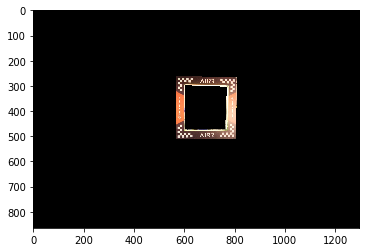

In [14]:
# testing annotation all together 

def get_mask(img_shape, poly,display=False):
     

    mask = np.zeros(img_shape[:2], dtype=np.uint8)
    mask = PIL.Image.fromarray(mask)
    draw = PIL.ImageDraw.Draw(mask)
    polygons = []
    for pt in poly:
        a = (int(pt[0]), int(pt[1]))
        polygons.append(a)
    
    draw.polygon(xy=polygons, outline=1, fill=1)
    mask = np.array(mask, dtype=bool)
    if display:
        plt.imshow(mask)
        plt.show
    return mask
#getting the final mask
for i in range(100,110):#len(df)): # use one image only for testing

    img=cv2.imread(df_train['img_path'][i])
    row=img.shape[0]
    col=img.shape[1]
    img_shape = (row,col)
    outer_poly=df_train['outer_poly'][i] 
    print('outer poly',outer_poly)
    inner_poly=df_train['inner_poly'][i]
    print('inner_poly', list(inner_poly))
    outer_mask=get_mask(img_shape,outer_poly,display=False)
    inner_mask=get_mask(img_shape,inner_poly,display=False)
    inner_mask.dtype='uint8'
    outer_mask.dtype='uint8'
    final_mask=cv2.subtract(outer_mask,inner_mask)
    plt.imshow(cv2.bitwise_and(img,img,mask=final_mask))
    plt.show

# BiseNet Model

In [15]:
import keras
import tensorflow as tf
from keras.applications.xception import Xception,preprocess_input
from keras.optimizers import SGD
from keras.models import Model
from keras.layers import Conv2D, Input, Dense, Dropout, multiply, Dot, Concatenate,Add, GlobalAveragePooling2D
from keras.layers import BatchNormalization, Activation, AveragePooling2D, UpSampling2D
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.python.keras.callbacks import TensorBoard

from keras.layers.core import Lambda
from keras.backend import tf as ktf

Using TensorFlow backend.


In [16]:
def conv_bn_act(inputs, n_filters=64, kernel=(2, 2), strides=1, activation='relu'):

    conv = Conv2D(n_filters, kernel_size= kernel, strides = strides, data_format='channels_last')(inputs)
    conv = BatchNormalization()(conv)
    conv = Activation(activation)(conv)

    return conv


def conv_act(inputs, n_filters, kernel = (1,1), activation = 'relu', pooling = False):
    if pooling:
        conv = AveragePooling2D(pool_size=(1, 1), padding='same', data_format='channels_last')(inputs)
        conv = Conv2D(n_filters, kernel_size= kernel, strides=1)(conv)
        conv = Activation(activation)(conv)
    else:
        conv = Conv2D(n_filters, kernel_size= kernel, strides=1)(inputs)
        conv = Activation(activation)(conv)


    return conv


def CP_ARM(layer_13, layer_14):
    
    # Combine the up-sampled output feature of Global avg pooling and Xception features
    tail_avg = GlobalAveragePooling2D()(layer_14)
    tail_upS = UpSampling2D(size=(2, 2), data_format='channels_last', interpolation='nearest')(layer_14)
    tail = Add()([tail_avg, tail_upS])
    
    # ARM
    ARM_13 = ARM(layer_13, 1024)
    ARM_14 = ARM(layer_14, 2048)

    layer_13 = UpSampling2D(size=2, data_format='channels_last', interpolation='nearest')(ARM_13)
    layer_14 = UpSampling2D(size=2, data_format='channels_last', interpolation='nearest')(ARM_14)

    context_features = Concatenate(axis=-1)([layer_14, layer_13])
    context_features = Concatenate(axis=-1)([context_features, tail])

    context_features = UpSampling2D(size=2, data_format='channels_last', interpolation='nearest')(context_features)

    return context_features

def ARM(inputs, n_filters):
    
    # ARM (Attention Refinement Module)
    # Refines features at each stage of the Context path
    # Negligible computation cost
    arm = AveragePooling2D(pool_size=(1, 1), padding='same', data_format='channels_last')(inputs)
    arm = conv_bn_act(arm, n_filters, (1, 1), activation='sigmoid')
    arm = multiply([inputs, arm])

    return arm


def FFM(input_sp, input_cp, n_classes):
    
    # FFM (Feature Fusion Module)
    # used to fuse features from the SP & CP
    # because SP encodes low-level and CP high-level features
    ffm = Concatenate(axis=-1)([input_sp, input_cp])
    conv = conv_bn_act(ffm, n_classes, (3, 3), strides= 2)

    conv_1 = conv_act(conv, n_classes, (1,1), pooling= True)
    conv_1 = conv_act(conv_1, n_classes, (1,1), activation='sigmoid')

    ffm = multiply([conv, conv_1])
    ffm = Add()([conv, ffm])

    return ffm

In [17]:
# Model (Input & Preprocession)
inputs = Input(shape=(224,224,3))
x = Lambda(lambda image: ktf.image.resize_images(image, (224, 224)))(inputs)
x = Lambda(lambda image: preprocess_input(image))(x)

# Spatial Path (conv_bn_act with strides = 2 )
SP = conv_bn_act(inputs, 32, strides=2)
SP = conv_bn_act(SP, 64, strides=2)
SP = conv_bn_act(SP, 156, strides=2)

# Context_path (Xception backbone and Attetion Refinement Module(ARM))
Xception_model = Xception(weights='imagenet',input_shape= (224,224,3), include_top=False)

# 16x Down
layer_13 = Xception_model.get_layer('block13_pool').output
# 32x Down
layer_14 = Xception_model.output
# Context path & ARM
# CP_ARM = CP_ARM(layer_13, layer_14)
cp_arm = CP_ARM(layer_13, layer_14)


# Feature Fusion Module(FFM)
ffm = FFM(SP, cp_arm, 32)

# Upsampling the ouput to normal size
output = UpSampling2D(size=(16,16), data_format='channels_last', interpolation='nearest')(ffm)


bisenet = Model(inputs = [inputs, Xception_model.input], output = [output, layer_13, layer_14])

print(bisenet.summary())

# We can visualize if our model was properly configure here 
from keras.utils import plot_model
plot_model(bisenet, to_file='model.png')


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [20]:
#build a generater
from object_segmentation_pipelines.Enet.ImgAugumentation import ImgAugumentation
img_augumentation = ImgAugumentation()
def loader(df, batch_size, im_size=(224,224), aug=False):
    total_files_s=len(df)
    if str(batch_size).lower() == 'all':
        batch_size = total_files_s
    idx = 0
    while(1):
      # Choosing random indexes of images and labels
        batch_idxs = np.random.randint(0, total_files_s, batch_size)
   
        
        inputs = []
        labels = []
        
        for jj in batch_idxs:
          # Reading normalized photo
        
 
            img = plt.imread(df['img_path'][jj])
            orginal_im_size=img.shape
          # Resizing using nearest neighbor method
            img = cv2.resize(img, (im_size[0], im_size[1]), cv2.INTER_NEAREST)
            
          # creating semantic mask 
            outer_poly=df['outer_poly'][jj] 
            #print('outer poly',outer_poly)
            inner_poly=df['inner_poly'][jj]
            #print('inner_poly', list(inner_poly))
            if len(outer_poly) > 1:
                outer_mask=get_mask((orginal_im_size[0], orginal_im_size[1]),outer_poly,display=False)
                inner_mask=get_mask((orginal_im_size[0], orginal_im_size[1]),inner_poly,display=False)
                inner_mask.dtype='uint8'
                outer_mask.dtype='uint8'
                final_mask=cv2.subtract(outer_mask,inner_mask)
              # Resizing using nearest neighbor method
                final_mask = cv2.resize(final_mask, (im_size[0], im_size[1]), cv2.INTER_NEAREST)
                if aug:
                    rand_value_augument = np.random.randint(7)
                    if (rand_value_augument == 0):   
                        img, final_mask=img_augumentation.flip_image_horz(img, final_mask)
                    if (rand_value_augument == 1): 
                        img, final_mask=img_augumentation.flip_image_ver(img, final_mask)
                    if (rand_value_augument == 2) or (rand_value_augument == 3): 
                        img=img_augumentation.brightness_images(img)
                    if (rand_value_augument == 4): 
                        img, final_mask =img_augumentation.trans_image(img,final_mask,50)
                    if (rand_value_augument == 5): 
                        img, final_mask =img_augumentation.stretch_image(img, final_mask,-100)
                    if (rand_value_augument == 6): 
                        img, final_mask =img_augumentation.stretch_image(img, final_mask,-50)
                    if (rand_value_augument == 7): 
                        img, final_mask =img_augumentation.stretch_image(img, final_mask,+30)
                inputs.append(img)
                labels.append(final_mask)

#         inputs = np.stack(inputs, axis=2)
#       # Changing image format to C x H x W
#         inputs = inputs.transpose(0, 2).transpose(1, 3)
        
#         labels = tf.convert_to_tensor(labels)
        
        yield inputs, labels

(224, 224)


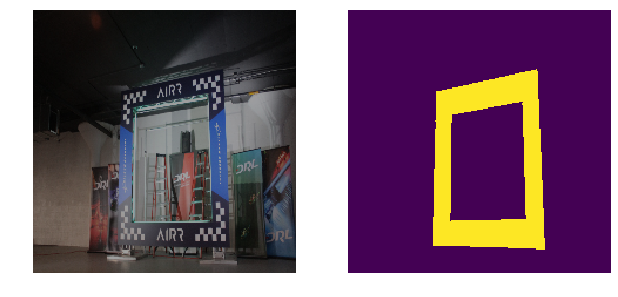

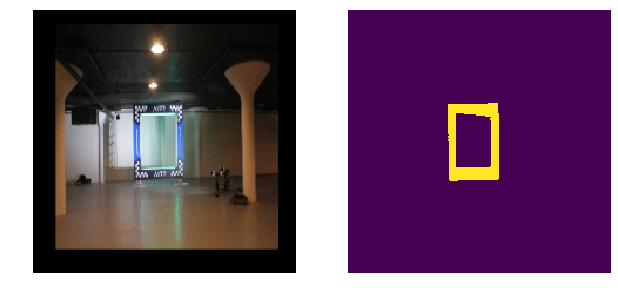

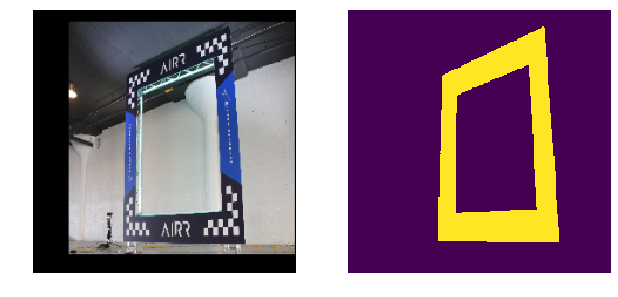

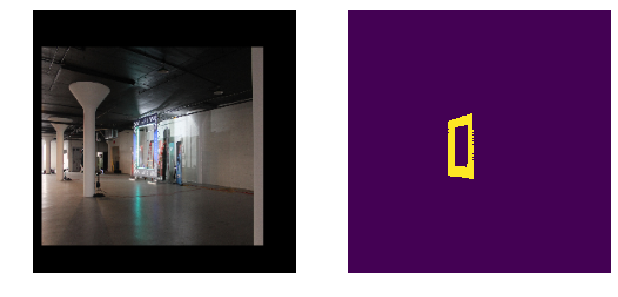

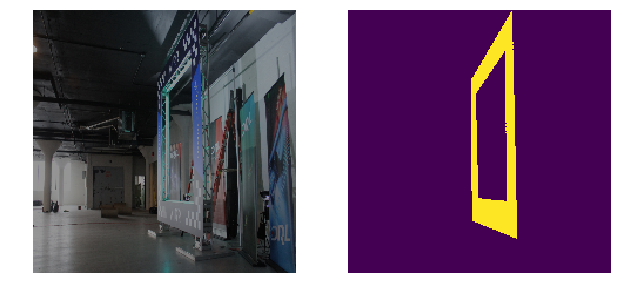

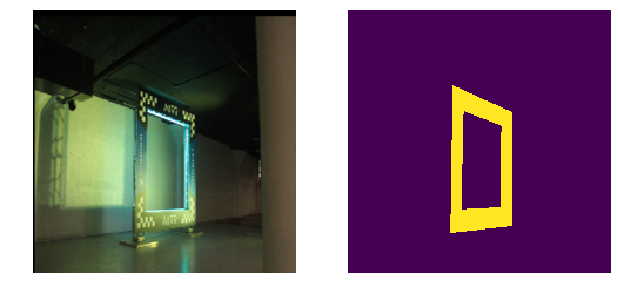

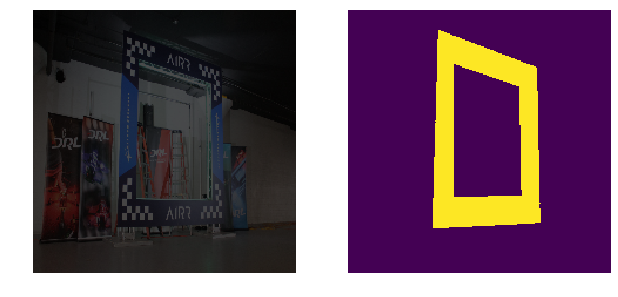

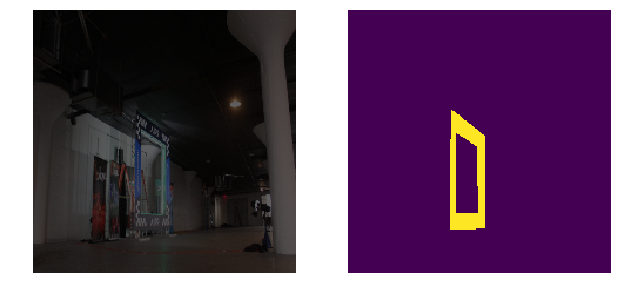

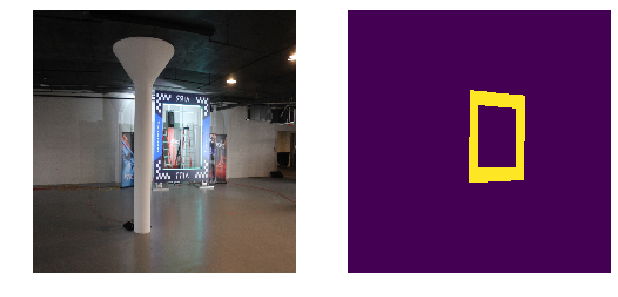

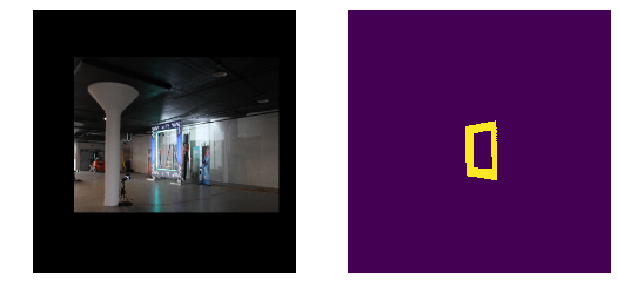

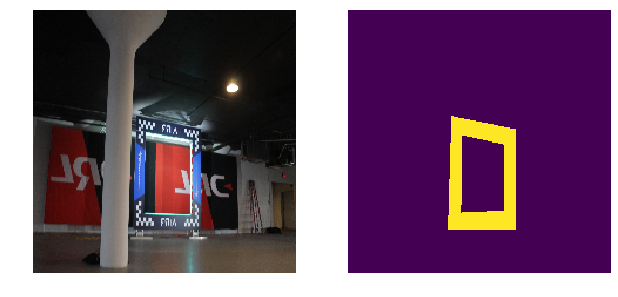

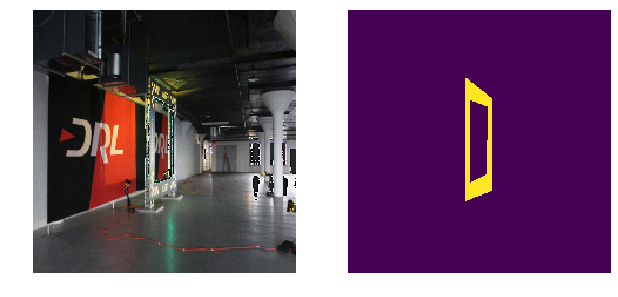

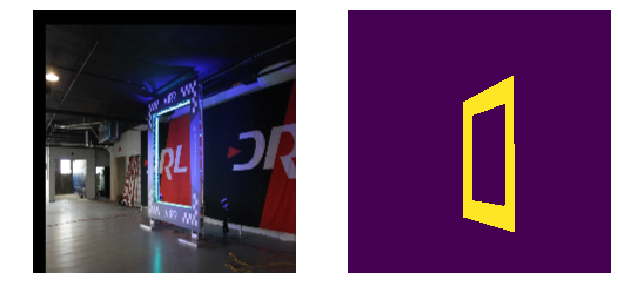

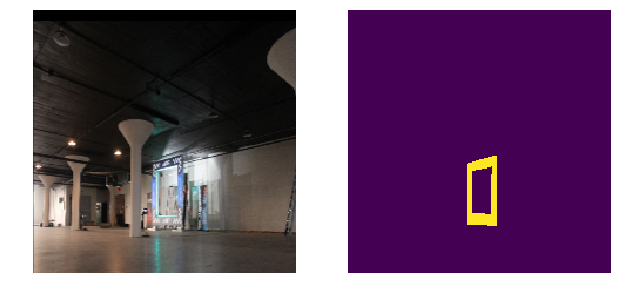

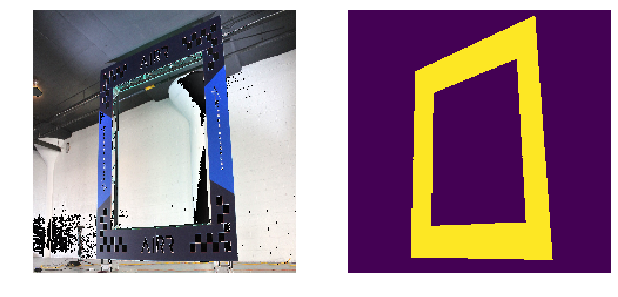

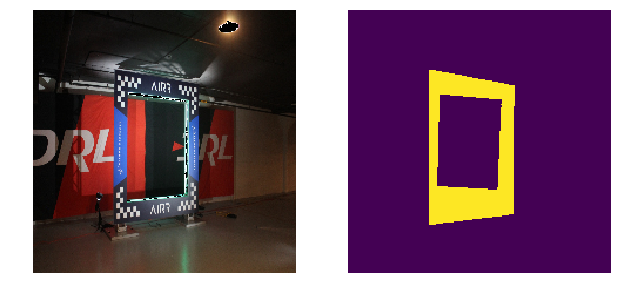

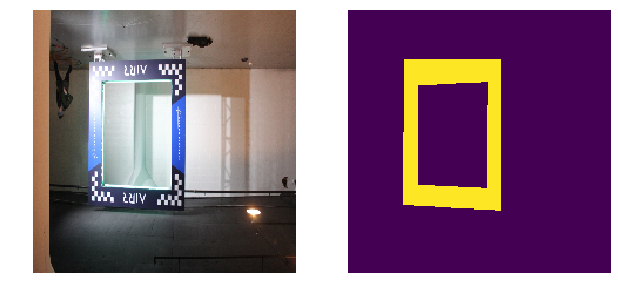

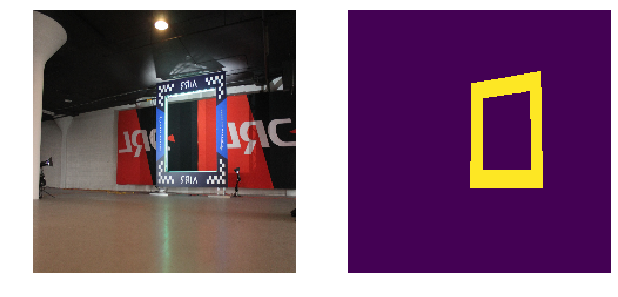

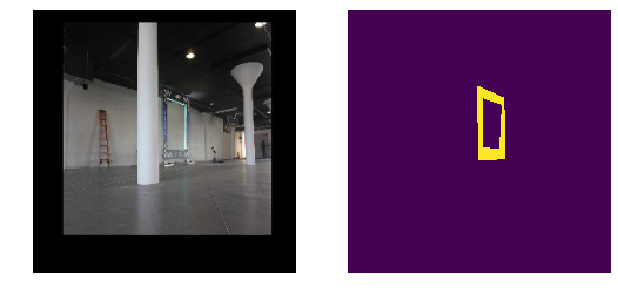

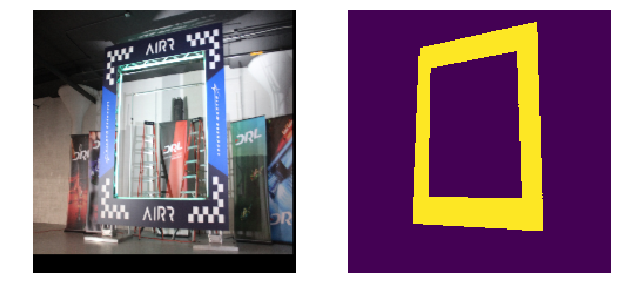

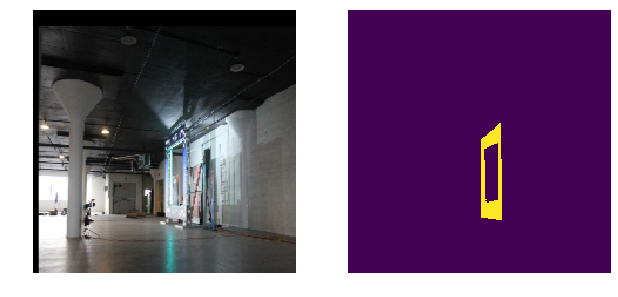

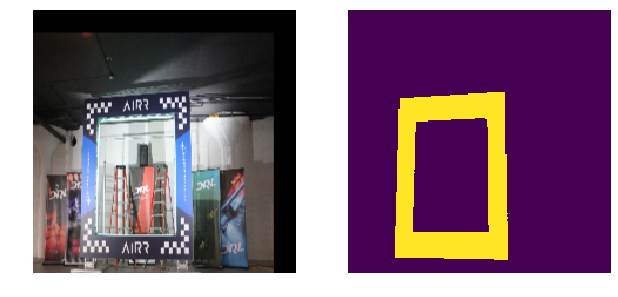

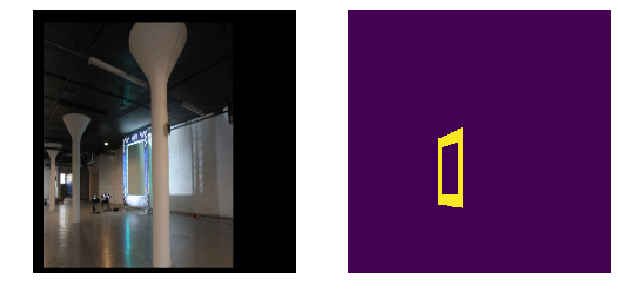

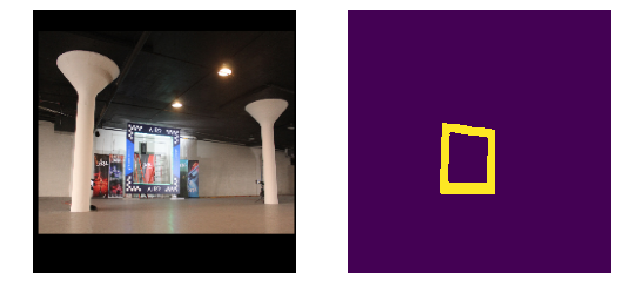

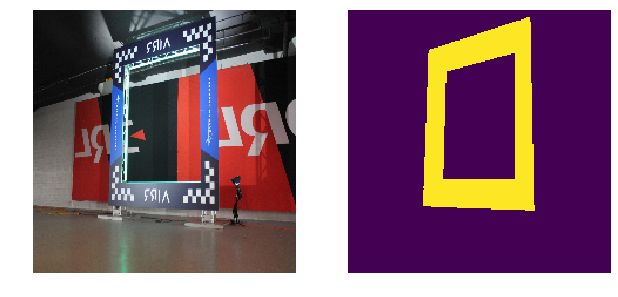

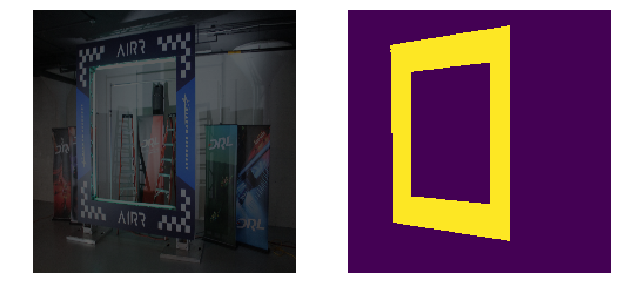

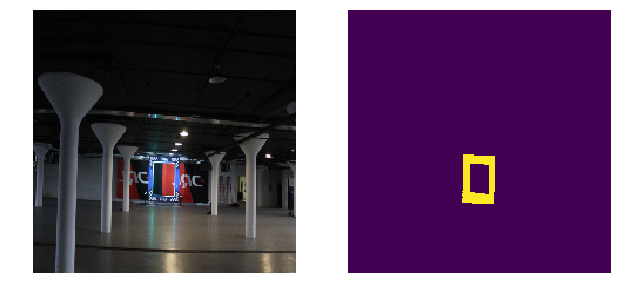

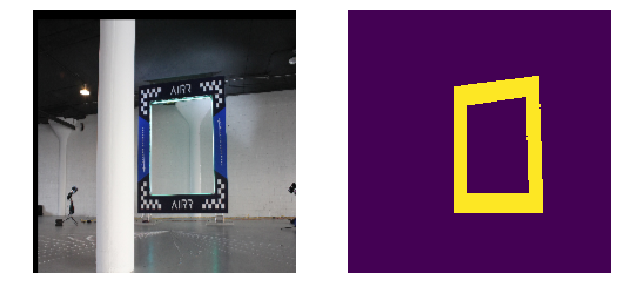

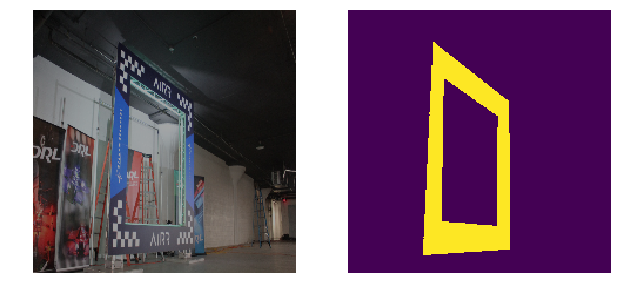

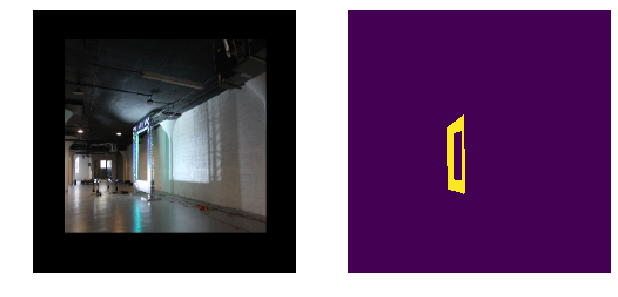

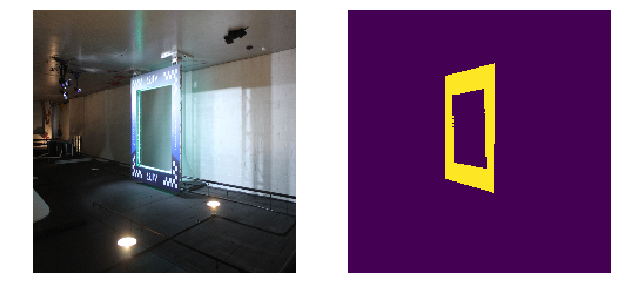

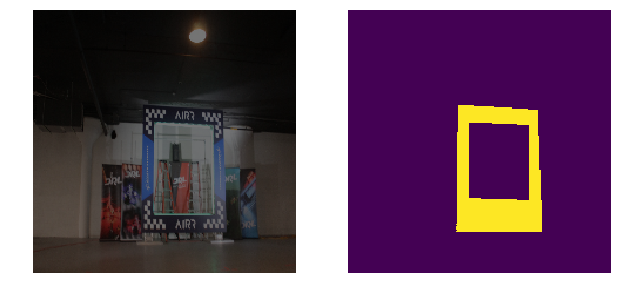

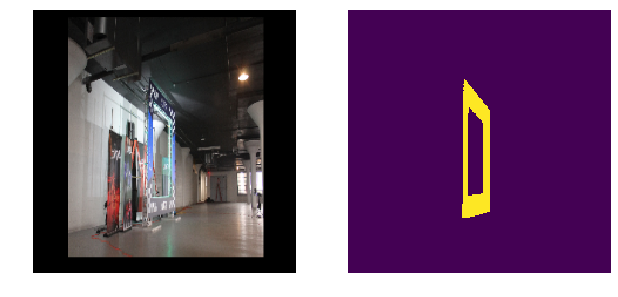

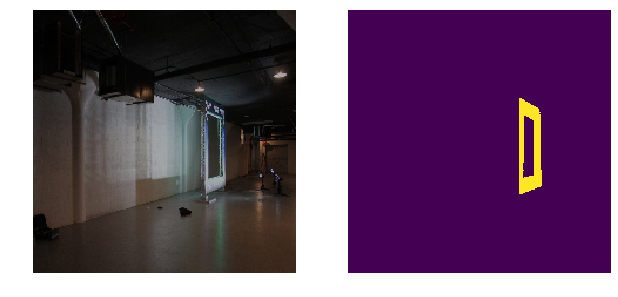

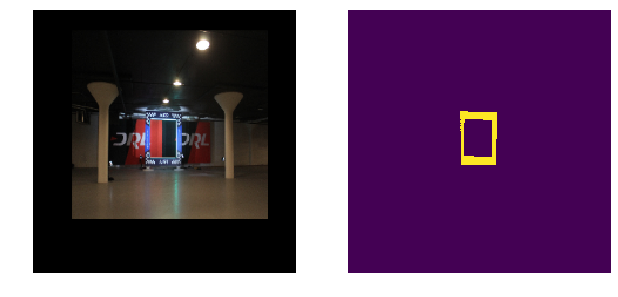

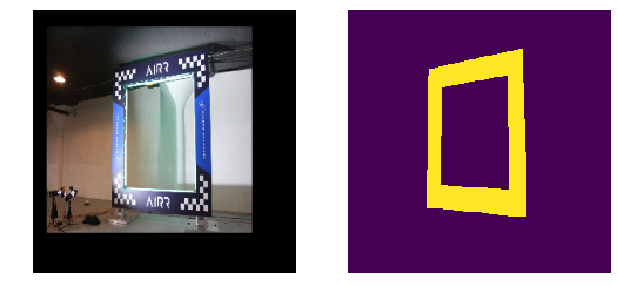

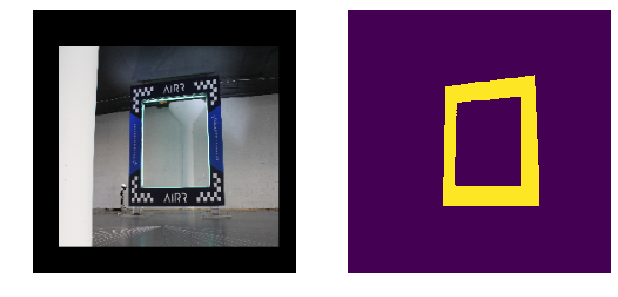

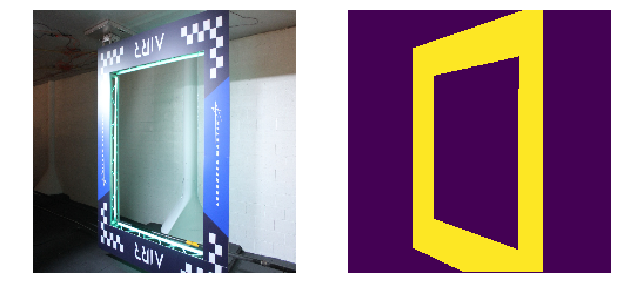

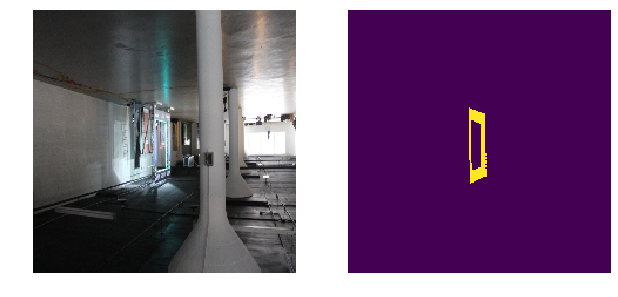

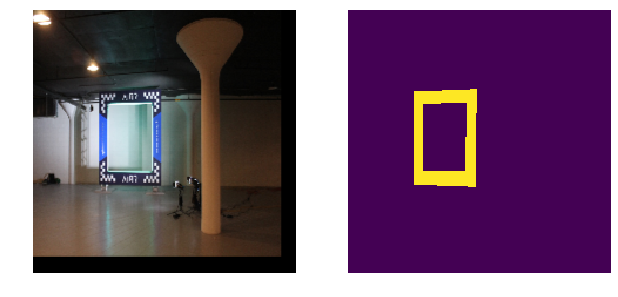

In [21]:
#test the generater
batch_size=40
training_gen=loader(df_train, batch_size, aug=True)
batch_img,batch_mask = next(training_gen)
print(batch_mask[0].shape)

for i in range(0,len(batch_img)):
 
    plt.figure(figsize=(16,16))
    plt.subplot(1,3,1)
    plt.imshow(batch_img[i])
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(batch_mask[i])
    plt.axis('off')

    plt.show();

In [22]:
#splitting the dataset into training and testing
from sklearn.model_selection import train_test_split
df_trn, df_tst = train_test_split(df_train, test_size=0.03)
print(len(df_trn))
print(len(df_tst))

df_trn.reset_index(drop=True, inplace=True)
df_tst.reset_index(drop=True, inplace=True)

4794
149


In [23]:
bc_train = 100# 1 // batch_size # mini_batch train
bc_eval = 77# // batch_size  # mini_batch validation
batch_size = 'all'

# Define pipeline objects
pipe = loader(df_trn, batch_size,aug=True)
test_pipe = loader(df_tst, batch_size)

In [24]:
train_img,train_mask = next(pipe)
test_img,test_mask = next(test_pipe)

In [26]:
bisenet.compile(loss='mean_squared_error', optimizer='sgd')

In [27]:
from keras.callbacks import ModelCheckpoint
model_checkpoint = ModelCheckpoint('bisenet.hdf5', monitor='loss',verbose=1, save_best_only=True)

In [28]:
bisenet.fit(train_data, batch_size=32, epochs=5, callbacks=model_checkpoint)

NameError: name 'train_data' is not defined

In [ ]:
train_img[0].shape

In [ ]:
train_mask[0].shape

In [ ]:
train_data = [train_img, train_mask]

In [ ]:
len(train_img)